In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import json
import re

#%pip install git+https://github.com/CAG-ru/susanin --upgrade

pd.set_option('display.max_colwidth', None)

## Данные детских садов с data.gov.ru
### Соберём данные по API

In [2]:
data_url = 'https://data.gov.ru/api/json/dataset/'
api_params = {
    'access_token' : '8daca1c147a591cd0d222e77caf1b66a',
    'topic' : 'education'
}
r = requests.get(data_url, params=api_params)
datasets = json.loads(r.content)

In [3]:
titles = [data['title'] for data in datasets]
list(filter(lambda x: re.search('(дошкол|сад)', x.lower()), titles))[:5]

['Сведения о функционировании системы дошкольного образования',
 'Дошкольные образовательные учреждения города Ульяновска',
 'Дошкольные образовательные учреждения города Димитровграда',
 'Дошкольные образовательные учреждения, расположенные на территории муниципального образования “Чердаклинский район”',
 'Дошкольные образовательные учреждения, расположенные на территории муниципального образования "Тереньгульский район"']

In [4]:
def filter_to_kindergartens(dataset):
    if not dataset['organization_name']:
        return False
    in_to = re.search('нижегоро', dataset['organization_name'].lower())
    title = dataset['title'].lower()
    is_kindergarten = title and re.search('(дошкол|сад)', title)
    return in_to and is_kindergarten

kita_dsets = list(filter(filter_to_kindergartens, datasets))

In [5]:
def collect_versions(dataset):
    query = 'https://data.gov.ru/api/json/dataset/' + dataset['identifier']
    ds_meta_info = json.loads(requests.get(query, params=api_params).text)
    ds_meta_info['created_'] = ds_meta_info['created']
    ds_meta_info['modified_'] = ds_meta_info['modified']
    ds_meta_info['created'] =  pd.to_datetime(ds_meta_info['created_'])
    ds_meta_info['modified'] = pd.to_datetime(ds_meta_info['modified_'])
    if ds_meta_info['modified'] < ds_meta_info['created']:
        ds_meta_info['modified'] = ds_meta_info['created']
        ds_meta_info['modified_'] = ds_meta_info['created_']
        
    return ds_meta_info

kita_dsets = list(map(collect_versions, kita_dsets))

In [6]:
kita_dsets[0]

{'identifier': '5231000960-mdou',
 'title': 'Дошкольные образовательные учреждения Сосновского муниципального района Нижегородской области',
 'description': 'Список дошкольных образовательных учреждений Соновского муниципального района с указанием контактных данный, адресов официальных сайтов и фактического адреса',
 'creator': 'Администрация Сосновского муниципального района Нижегородской области',
 'created': Timestamp('2014-10-09 00:00:00'),
 'modified': Timestamp('2019-10-03 16:51:29'),
 'format': 'csv',
 'subject': 'детсад,Сосновское,образование,Сосновский район,ДОУ',
 'created_': '20141009T000000',
 'modified_': '20191003T165129'}

In [7]:
years = set(dset['created'].year for dset in kita_dsets).union(
    set(dset['modified'].year for dset in kita_dsets))
years

{2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021}

In [8]:
def collect_data(dataset):
    result = []
    try:
        for timestamp in set([dataset['created_'], dataset['modified_']]):
            query = 'https://data.gov.ru/api/json/' + \
                'dataset/' + dataset['identifier'] + \
                '/version/' + timestamp + '/content'
            ds = pd.DataFrame(json.loads(requests.get(query, params=api_params).text))
            if len(ds) > 0:
                ds['Датасет'] = dataset['title']
                ds['Дата'] = pd.to_datetime(timestamp)
                ds['Год'] = pd.to_datetime(timestamp).year
                ds['Источник'] = dataset['creator']
                result.append(ds)
        return result
    except:
        return []

kita_contents = []
for ds in kita_dsets:
    kita_contents.extend(collect_data(ds))

### Унифицируем колонки датасетов и смерджим в один


In [9]:
from workshop_utils import normalise_colnames, bad_sources, normalise_order, postprocess

ready_dfs = list(map(normalise_colnames, 
        filter(lambda x: not bad_sources(x), kita_contents)))

for df in ready_dfs:
    normalise_order(df)
    
kita_df = pd.concat(ready_dfs)

In [10]:
kita_df.head()

,name,address,director,phone_no,email,title,date,year,source
0,"1,МКБДОУ детский сад присмотра и оздоровления № 1""",607060 Нижегородская область г. Выкса переулок Пионера здание №7,Шуянова Татьяна Александровна,3-52-51,"detskiy.sad1@mail.ru""",Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области
1,"2,МБДОУ детский сад № 2 «Ромашка»""",607061 Нижегородская область г. Выкса ул. Ульянова здание № 4,Борисова Юлия Александровна,6-16-23,"romaschka-w@yandex.ru""",Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области
2,"3,МБДОУ детский сад комбинированного вида № 3 «Ручеек»""",607062 Нижегородская область г. Выкса м-н Юбилейный здание №54,Агафонова Елена Юрьевна,4-39-98,"agafonowael@yandex.ru""",Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области
3,"4,МБДОУ детский сад комбинированного вида № 4""",607067 Нижегородская область г. Выкса ул. Лазо зд. № 79,Лукашова Алла Вячеславовна,6-78-40,"mbdou2012@yandex.ru """,Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области
4,"5,МБДОУ детский сад № 6 «Ладушки»""",607061 Нижегородская область г.Выкса ул. Чкалова зд.№ 3,Егорова Наталья Евгеньевна,3-54-03,"ladushkisad@yandex.ru""",Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области


### Нормализуем адреса
Где находятся все эти детские сады?

In [41]:
# Инициализация геонормалайзера

from geonorm.geonormaliser_utils import decompose
from geonorm.geomatch import Geomatch
from geonorm.geonormaliser_utils import get_standard

get_standard(fname='standard')
standard_df = pd.read_csv('standard.zip', compression='zip', sep=';')

# Пофильтруем датасет до Нижегородской области
standard_df_nn = standard_df[standard_df['region']=='Нижегородская']
for col in standard_df_nn.columns:
    standard_df_nn[col] = standard_df_nn[col].astype(str)
display(standard_df_nn.head(1))

/opt/homebrew/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (1,2,3,4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-41-79c524f6638c>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  standard_df_nn[col] = standard_df_nn[col].astype(str)


,region,municipality,municipality_type,settlement,settlement_type,location,location_type,street,street_type,house,source
7196968,Нижегородская,nan,nan,Арзамас,город,nan,nan,Комсомольский,бульвар,дом 2,2


In [12]:
# Примеры декомпозиции

example = '607060  Нижегородская область  г. Выкса  переулок Пионера  здание №7'
decompose(example)

{'region': 'Нижегородская',
 'region_type': 'область',
 'municipality': '',
 'municipality_type': '',
 'settlement': 'Выкса',
 'settlement_type': 'город',
 'street': 'Пионера',
 'street_type': 'переулок',
 'house': 'дом №7',
 'location': '',
 'location_type': '',
 'not_decompose': '607060'}

In [13]:
# Инициализация матчинга

useful_cols = ['municipality', 'settlement', 'street']
matcher = Geomatch(standard_df_nn, match_columns=useful_cols)

In [14]:
# Пример матчинга 

matcher(decompose(example))

{'region': 'Нижегородская',
 'municipality': 'None',
 'municipality_type': 'None',
 'settlement': 'Выкса',
 'settlement_type': 'город',
 'location': 'None',
 'location_type': 'None',
 'street': 'Пионера',
 'street_type': 'переулок',
 'house': 'дом 2',
 'source': '2',
 'settlement_oktmo': 'г Выкса',
 'score': '0.9178398169864032',
 'region_oktmo': 'Нижегородская область',
 'municipality1': 'город Выкса',
 'municipality2': '',
 'municipality1_type': 'Городской округ',
 'municipality2_type': '',
 'results_count': 11,
 'skiped_dead_end_fields': 0}

In [15]:
# Соберем декомпозицию и матчинга для адресов всех детских садов

# декомпощиция
addresses = kita_df[['address']].apply(lambda row: 
                        decompose(row[0]), axis=1, result_type="expand")
addresses.head()

,region,region_type,municipality,municipality_type,settlement,settlement_type,street,street_type,house,location,location_type,not_decompose
0,Нижегородская,область,,,Выкса,город,Пионера,переулок,дом №7,,,607060
1,Нижегородская,область,,,Выкса,город,Ульянова,улица,дом № 4,,,607061
2,Нижегородская,область,,,Выкса,город,,,дом №54,,,607062 м-н Юбилейный
3,Нижегородская,область,,,Выкса,город,Лазо,улица,,,,607067 зд. № 79
4,Нижегородская,область,,,Выкса,город,Чкалова,улица,,,,607061 зд.№ 3


In [16]:
# матчинг

norm_addresses = matcher(addresses)
norm_addresses.head()

,region,municipality,municipality_type,settlement,settlement_type,location,location_type,street,street_type,house,source,settlement_oktmo,score,region_oktmo,municipality1,municipality2,municipality1_type,municipality2_type,results_count,skiped_dead_end_fields
0,Нижегородская,None,None,Выкса,город,None,None,Пионера,переулок,дом 2,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,11,0
1,Нижегородская,None,None,Выкса,город,Гаражный квартал N25,территория,Ульянова,улица,дом 2595,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,32,0
2,Нижегородская,None,None,Выкса,город,Досчатое,рабочий поселок,Пушкина,улица,дом 51,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,24086,0
3,Нижегородская,None,None,Выкса,город,None,None,Лазо,улица,дом 7,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,73,0
4,Нижегородская,None,None,Выкса,город,Досчатое,рабочий поселок,Чкалова,улица,дом 25,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,192,0


In [17]:
norm_addresses.municipality.value_counts()

None            62
Сеченовский     36
Починковский    36
Княгининский    26
Спасский        20
Выкса           20
Сергачский      16
Шатковский      16
Кулебаки        16
Сокольский      15
Бутурлинский    12
Сергач           6
Name: municipality, dtype: int64

In [18]:
# Объединим назад

kita_normalised = pd.concat([kita_df, norm_addresses], axis=1)
kita_normalised.head()

,name,address,director,phone_no,email,title,date,year,source,region,...,source,settlement_oktmo,score,region_oktmo,municipality1,municipality2,municipality1_type,municipality2_type,results_count,skiped_dead_end_fields
0,"1,МКБДОУ детский сад присмотра и оздоровления № 1""",607060 Нижегородская область г. Выкса переулок Пионера здание №7,Шуянова Татьяна Александровна,3-52-51,"detskiy.sad1@mail.ru""",Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области,Нижегородская,...,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,11,0
1,"2,МБДОУ детский сад № 2 «Ромашка»""",607061 Нижегородская область г. Выкса ул. Ульянова здание № 4,Борисова Юлия Александровна,6-16-23,"romaschka-w@yandex.ru""",Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области,Нижегородская,...,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,32,0
2,"3,МБДОУ детский сад комбинированного вида № 3 «Ручеек»""",607062 Нижегородская область г. Выкса м-н Юбилейный здание №54,Агафонова Елена Юрьевна,4-39-98,"agafonowael@yandex.ru""",Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области,Нижегородская,...,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,24086,0
3,"4,МБДОУ детский сад комбинированного вида № 4""",607067 Нижегородская область г. Выкса ул. Лазо зд. № 79,Лукашова Алла Вячеславовна,6-78-40,"mbdou2012@yandex.ru """,Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области,Нижегородская,...,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,73,0
4,"5,МБДОУ детский сад № 6 «Ладушки»""",607061 Нижегородская область г.Выкса ул. Чкалова зд.№ 3,Егорова Наталья Евгеньевна,3-54-03,"ladushkisad@yandex.ru""",Дошкольные образовательные учреждения городского округа город Выкса Нижегородской области,2014-09-26,2014,Администрация городского округа город Выкса Нижегородской области,Нижегородская,...,2,г Выкса,0.9178398169864032,Нижегородская область,город Выкса,,Городской округ,,192,0


### Агрегируем детские сады по муниципальным образованиям

In [19]:
kita_num_df = kita_normalised.groupby(['year', 'municipality', 
                                       'municipality_type']).size().reset_index(name='counts')
kita_num_df.sort_values(['year', 'counts'], ascending=False)

,year,municipality,municipality_type,counts
21,2020,Сеченовский,район,18
17,2020,None,None,11
18,2020,Кулебаки,город,8
20,2020,Сергачский,район,8
22,2020,Шатковский,район,8
19,2020,Сергач,город,3
14,2018,None,None,20
16,2018,Выкса,город,10
15,2018,Бутурлинский,район,6
12,2017,Княгининский,район,26


## Все ли МО то, чем кажутся?

In [20]:
from ovrazhki.ovrazhki import Ovrazhki                                                                
        
my_ovrazhki = Ovrazhki('Нижегородская обла')
pd.set_option('display.max_row', None)

panel_num = my_ovrazhki.check_my_panel(kita_num_df,
                truncate_to_year=True, mun_type='municipality_type')

INFO:root:Региона "Нижегородская обла" в базе нет. Продолжаю с "Нижегородская область"


In [21]:
panel_num.sort_values(['municipality', 'year'])#.to_excel('kita_panel.xlsx')

,year,municipality,municipality_type,counts,mun_type,id,hash,oktmo,municipality_standard,lvl,odate_start,odate_end,region,mun_type_standard,message,duplicates,last_hash,territory_closeness,settlement_changes,join_panels
0,2014-01-01,None,None,20,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,< 2015 no data,NaN,NaN,NaN,NaN,NaN
14,2016-01-01,None,None,11,None,5691.0,ff63a1e61dc77ef6d2ac4aed28de3ccc,22618154.0,рабочий поселок им М.И. Калинина,2.0,2015-01-28,2021-11-03,Нижегородская область,Городское поселение,ok,,ff63a1e61dc77ef6d2ac4aed28de3ccc,1.0,,
15,2018-01-01,None,None,20,None,5691.0,ff63a1e61dc77ef6d2ac4aed28de3ccc,22618154.0,рабочий поселок им М.И. Калинина,2.0,2015-01-28,2021-11-03,Нижегородская область,Городское поселение,ok,,ff63a1e61dc77ef6d2ac4aed28de3ccc,1.0,,
16,2020-01-01,None,None,11,None,5691.0,ff63a1e61dc77ef6d2ac4aed28de3ccc,22618154.0,рабочий поселок им М.И. Калинина,2.0,2015-01-28,2021-11-03,Нижегородская область,Городское поселение,ok,,ff63a1e61dc77ef6d2ac4aed28de3ccc,1.0,,
1,2014-01-01,Бутурлинский муниципальный район,район,6,Муниципальный район,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,< 2015 no data,NaN,NaN,NaN,NaN,NaN
0,2018-01-01,Бутурлинский муниципальный район,район,6,Муниципальный район,5661.0,2bd7e5e442e7ac256f27bb9b49158231,22612000.0,Бутурлинский муниципальный район,1.0,2015-01-28,2021-01-01,Нижегородская область,Муниципальный район,ok,,2bd7e5e442e7ac256f27bb9b49158231,1.0,,
2,2014-01-01,Выкса,город,10,город,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,< 2015 no data,NaN,NaN,NaN,NaN,NaN
9,2018-01-01,Выкса,город,10,город,6013.0,881c060a0549196536707dd46bee84c5,22715000.0,город Выкса,1.0,2015-01-28,2018-04-26,Нижегородская область,Городской округ,more than one MO with that name! see duplicates,"6013, 6014",881c060a0549196536707dd46bee84c5,1.0,,
1,2017-01-01,Княгининский муниципальный район,район,26,Муниципальный район,5783.0,ccd2229583870d95ad266884f6b708e4,22633000.0,Княгининский муниципальный район,1.0,2015-01-28,2021-11-03,Нижегородская область,Муниципальный район,ok,,ccd2229583870d95ad266884f6b708e4,1.0,,
10,2016-01-01,Кулебаки,город,8,город,6017.0,a0e7a3a202529d4dc0e1e0e3eeba3530,22727000.0,город Кулебаки,1.0,2015-12-23,2021-11-03,Нижегородская область,Городской округ,ok,,a0e7a3a202529d4dc0e1e0e3eeba3530,1.0,,


In [22]:
my_ovrazhki.get_municipalities_by_id(6013)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,id,hash,oktmo,municipality,lvl,odate_start,odate_end,region,mun_type,time_start,time_end
6012,6013,881c060a0549196536707dd46bee84c5,22715000,город Выкса,1,2015-01-28,2018-04-26,Нижегородская область,Городской округ,2015-01-01,2019-01-01


In [23]:
my_ovrazhki.get_municipalities_by_id(6014)

,id,hash,oktmo,municipality,lvl,odate_start,odate_end,region,mun_type,time_start,time_end
6013,6014,a1bdb43d941770db54c605996a2144d2,22715000,город Выкса,1,2018-06-15,2021-11-03,Нижегородская область,Городской округ,2018-01-01,2022-01-01


In [24]:
kita_normalised[(kita_normalised['municipality'] == 'город Выкса') & (kita_normalised.year == 2018)].head(1)

,name,address,director,phone_no,email,title,date,year,source,region,...,source,settlement_oktmo,score,region_oktmo,municipality1,municipality2,municipality1_type,municipality2_type,results_count,skiped_dead_end_fields


In [25]:
my_ovrazhki.calculate_similarity('881c060a0549196536707dd46bee84c5',
                                'a1bdb43d941770db54c605996a2144d2')

({'п Домики'}, 0.9791666666666666)

### Ориентируемся на хэши

In [26]:
kita_panel = panel_num[~panel_num['hash'].isna()].copy()
kita_panel.sort_values('hash')

,year,municipality,municipality_type,counts,mun_type,id,hash,oktmo,municipality_standard,lvl,odate_start,odate_end,region,mun_type_standard,message,duplicates,last_hash,territory_closeness,settlement_changes,join_panels
0,2018-01-01,Бутурлинский муниципальный район,район,6,Муниципальный район,5661.0,2bd7e5e442e7ac256f27bb9b49158231,22612000.0,Бутурлинский муниципальный район,1.0,2015-01-28,2021-01-01,Нижегородская область,Муниципальный район,ok,,2bd7e5e442e7ac256f27bb9b49158231,1.0,,
13,2020-01-01,Сергач,город,3,город,5908.0,4b88b9f40ae5d9cef6c09f5b5733171c,22648101.0,город Сергач,2.0,2015-01-28,2021-11-03,Нижегородская область,Городское поселение,ok,,4b88b9f40ae5d9cef6c09f5b5733171c,1.0,,
12,2015-01-01,Сергач,город,3,город,5908.0,4b88b9f40ae5d9cef6c09f5b5733171c,22648101.0,город Сергач,2.0,2015-01-28,2021-11-03,Нижегородская область,Городское поселение,ok,,4b88b9f40ae5d9cef6c09f5b5733171c,1.0,,
8,2020-01-01,Шатковский муниципальный район,район,8,Муниципальный район,5996.0,6c73764fd8a233156ac58a56ca454686,22657000.0,Шатковский муниципальный район,1.0,2015-01-28,2021-11-03,Нижегородская область,Муниципальный район,ok,,6c73764fd8a233156ac58a56ca454686,1.0,,
9,2018-01-01,Выкса,город,10,город,6013.0,881c060a0549196536707dd46bee84c5,22715000.0,город Выкса,1.0,2015-01-28,2018-04-26,Нижегородская область,Городской округ,more than one MO with that name! see duplicates,"6013, 6014",881c060a0549196536707dd46bee84c5,1.0,,
10,2016-01-01,Кулебаки,город,8,город,6017.0,a0e7a3a202529d4dc0e1e0e3eeba3530,22727000.0,город Кулебаки,1.0,2015-12-23,2021-11-03,Нижегородская область,Городской округ,ok,,a0e7a3a202529d4dc0e1e0e3eeba3530,1.0,,
11,2020-01-01,Кулебаки,город,8,город,6017.0,a0e7a3a202529d4dc0e1e0e3eeba3530,22727000.0,город Кулебаки,1.0,2015-12-23,2021-11-03,Нижегородская область,Городской округ,ok,,a0e7a3a202529d4dc0e1e0e3eeba3530,1.0,,
2,2015-01-01,Сергачский муниципальный район,район,8,Муниципальный район,5907.0,a587ec4947eaae22abae0651ec5f4955,22648000.0,Сергачский муниципальный район,1.0,2015-01-28,2021-11-03,Нижегородская область,Муниципальный район,ok,,a587ec4947eaae22abae0651ec5f4955,1.0,,
3,2020-01-01,Сергачский муниципальный район,район,8,Муниципальный район,5907.0,a587ec4947eaae22abae0651ec5f4955,22648000.0,Сергачский муниципальный район,1.0,2015-01-28,2021-11-03,Нижегородская область,Муниципальный район,ok,,a587ec4947eaae22abae0651ec5f4955,1.0,,
1,2017-01-01,Княгининский муниципальный район,район,26,Муниципальный район,5783.0,ccd2229583870d95ad266884f6b708e4,22633000.0,Княгининский муниципальный район,1.0,2015-01-28,2021-11-03,Нижегородская область,Муниципальный район,ok,,ccd2229583870d95ad266884f6b708e4,1.0,,


## БДМО

In [27]:
places_num_bdmo_code = 't8014002' # код показателя мест в детских садах
bdmo_df = pd.read_csv('BDMO_01012018/1 indicator clean v2.csv')

nn_bdmo_df = bdmo_df[
    (bdmo_df.region == 'Нижегородская область') &
    (bdmo_df.year >= 2007)].copy()

nn_bdmo_df = nn_bdmo_df[[
    'mun_type',
    'municipality',
    'region',
    places_num_bdmo_code,
    'year'
]]

nn_bdmo_df.head()

,mun_type,municipality,region,t8014002,year
119895,Городское поселение,рабочий поселок Ардатов,Нижегородская область,460.0,2007
119896,Городское поселение,рабочий поселок Выездное,Нижегородская область,295.0,2007
119897,Городское поселение,Город Балахна,Нижегородская область,2135.0,2007
119898,Городское поселение,Город Богородск,Нижегородская область,1359.0,2007
119899,Сельское поселение,Большеболдинский сельсовет,Нижегородская область,235.0,2007


In [28]:
panel_bdmo = my_ovrazhki.check_my_panel(nn_bdmo_df, truncate_to_year=True, mun_type='mun_type')

In [29]:
panel_matched = panel_bdmo[~panel_bdmo['hash'].isna()]
panel_matched['municipality_standard'] = panel_matched['municipality_standard'].astype(str)
kita_panel['municipality_standard'] = kita_panel['municipality_standard'].astype(str)

<ipython-input-29-598deb8c650a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel_matched['municipality_standard'] = panel_matched['municipality_standard'].astype(str)


### Простой EDA 

In [30]:
result = kita_panel.merge(
    panel_matched, 
    on=['hash', 'year', ], how='left')

In [31]:
result.head(2)

,year,municipality_x,municipality_type,counts,mun_type_x,id_x,hash,oktmo_x,municipality_standard_x,lvl_x,...,odate_start_y,odate_end_y,region_standard,mun_type_standard_y,message_y,duplicates_y,last_hash_y,territory_closeness_y,settlement_changes_y,join_panels_y
0,2018-01-01,Бутурлинский муниципальный район,район,6,Муниципальный район,5661.0,2bd7e5e442e7ac256f27bb9b49158231,22612000.0,Бутурлинский муниципальный район,1.0,...,2015-01-28,2021-01-01,Нижегородская область,Муниципальный район,ok,,2bd7e5e442e7ac256f27bb9b49158231,1.0,,
1,2017-01-01,Княгининский муниципальный район,район,26,Муниципальный район,5783.0,ccd2229583870d95ad266884f6b708e4,22633000.0,Княгининский муниципальный район,1.0,...,2015-01-28,2021-11-03,Нижегородская область,Муниципальный район,ok,,ccd2229583870d95ad266884f6b708e4,1.0,,


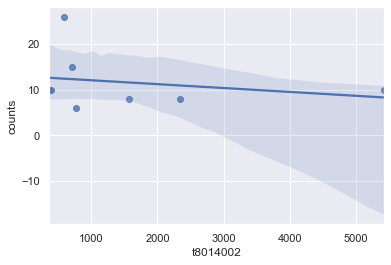

In [32]:
data=result[['t8014002', 'counts']]
import seaborn as sns; sns.set_theme(color_codes=True)
ax = sns.regplot(x='t8014002', y='counts', data=data)

In [33]:
data.corr()

,t8014002,counts
t8014002,1.000000,-0.229946
counts,-0.229946,1.000000


In [34]:
result[['t8014002', 'counts', 'municipality_standard_x']]

,t8014002,counts,municipality_standard_x
0,764.0,6,Бутурлинский муниципальный район
1,593.0,26,Княгининский муниципальный район
2,1572.0,8,Сергачский муниципальный район
3,NaN,8,Сергачский муниципальный район
4,NaN,18,Сеченовский муниципальный район
5,705.0,15,Сокольский
6,385.0,10,Спасский муниципальный район
7,367.0,10,Спасский муниципальный район
8,NaN,8,Шатковский муниципальный район
9,5422.0,10,город Выкса


In [35]:
kita_normalised[kita_normalised['municipality'] == 'Княгининский']

,name,address,director,phone_no,email,title,date,year,source,region,...,source,settlement_oktmo,score,region_oktmo,municipality1,municipality2,municipality1_type,municipality2_type,results_count,skiped_dead_end_fields
0,Муниципальное бюджетное дошкольное образовательное учреждение детский сад №1 «Теремок»,"Нижегородская область, г. Княгинино, ул. Ленина 72",Тесакова Наталья Александровна,8(83166) 4-10-41,natesacova@mail.ru,Сведения о муниципальных дошкольных образовательных учреждениях Княгининского района,2017-09-20 14:42:20,2017,Администрация Княгининского района Нижегородской области,Нижегородская,...,1,г Княгинино,0.929176154870881,Нижегородская область,Княгининский муниципальный район,город Княгинино,Муниципальный район,Городское поселение,14,0
1,Муниципальное бюджетное дошкольное образовательное учреждение детский сад №2 «Светлячок»,"Нижегородская область, Княгининский район, г. Княгинино, ул. Октябрьская 9а",Крупина Светлана Вячеславовна,8(83166) 4-18-63,krupina69@rambler.ru,Сведения о муниципальных дошкольных образовательных учреждениях Княгининского района,2017-09-20 14:42:20,2017,Администрация Княгининского района Нижегородской области,Нижегородская,...,1,г Княгинино,0.929176154870881,Нижегородская область,Княгининский муниципальный район,город Княгинино,Муниципальный район,Городское поселение,95,0
2,"Филиал муниципального бюджетного дошкольноего образовательного учреждения детского сада №2 «Светлячок» детский сад Островок""""","Нижегородская область, Княгининский район село Островское , ул.Садовая 1",Крупина Светлана Вячеславовна,8(83166) 36-4-43,krupina69@rambler.ru,Сведения о муниципальных дошкольных образовательных учреждениях Княгининского района,2017-09-20 14:42:20,2017,Администрация Княгининского района Нижегородской области,Нижегородская,...,1,с Островское,0.9785184786313252,Нижегородская область,Княгининский муниципальный район,Ананьевский сельсовет,Муниципальный район,Сельское поселение,8,0
3,"Муниципальное бюджетное дошкольное образовательное учреждение детский сад №3 Сказка""""","Нижегородская область, Княгининский район, г. Княгинино, 1 Микрорайон.д 6",Комарова Елена Евгеньевна,8(83166) 4-10-20,dsskazka67@mail.ru,Сведения о муниципальных дошкольных образовательных учреждениях Княгининского района,2017-09-20 14:42:20,2017,Администрация Княгининского района Нижегородской области,Нижегородская,...,1,г Княгинино,0.929176154870881,Нижегородская область,Княгининский муниципальный район,город Княгинино,Муниципальный район,Городское поселение,1,0
4,Муниципальное бюджетное дошкольное образовательное учреждение детский сад №4 «Улыбка»,"Нижегородская область, Княгининский район, г. Княгинино, ул. Октябрьская 9",Егорова Елена Владимировна,8(83166) 4-20-94,19eve63@mail.ru,Сведения о муниципальных дошкольных образовательных учреждениях Княгининского района,2017-09-20 14:42:20,2017,Администрация Княгининского района Нижегородской области,Нижегородская,...,1,г Княгинино,0.929176154870881,Нижегородская область,Княгининский муниципальный район,город Княгинино,Муниципальный район,Городское поселение,95,0
5,"Филиал муниципального бюджетного дошкольного образовательного учреждения детского сада №4 «Улыбка» детский сад Василёк""""","Нижегородская область, Княгининский район, село Белка, ул. Полевая 5а",Егорова Елена Владимировна,8(83166) 36-1-81,19eve63@mail.ru,Сведения о муниципальных дошкольных образовательных учреждениях Княгининского района,2017-09-20 14:42:20,2017,Администрация Княгининского района Нижегородской области,Нижегородская,...,1,с Белка,0.9639388476017059,Нижегородская область,Княгининский муниципальный район,Белкинский сельсовет,Муниципальный район,Сельское поселение,5,0
6,Муниципальное бюджетное дошкольное образовательное учреждение детский сад №8 «Калинушка»,"Нижегородская область, Княгининский район, д. Соловьёво, ул. Мира 5а",Воросова Татьяна Александровна,8(83166) 37-5-75,vorosovat@mail.ru,Сведения о муниципальных дошкольных образовательных учреждениях Княгининского района,2017-09-20 14:42:20,2017,Админи

In [36]:
kita_normalised[kita_normalised['municipality'] == 'Княгининский'].shape

(26, 29)

In [37]:
kita_normalised[kita_normalised['municipality'] == 'Княгининский'].drop_duplicates('name').shape

(13, 29)

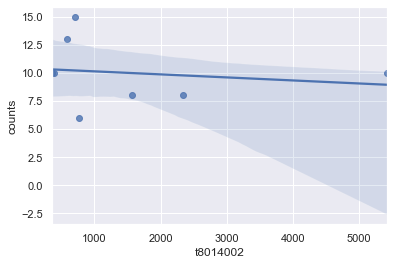

In [38]:
data.at[1, 'counts'] = 13
ax = sns.regplot(x='t8014002', y='counts', data=data)

In [39]:
data.corr()

,t8014002,counts
t8014002,1.000000,-0.160954
counts,-0.160954,1.000000
